**Wasserstein GAN (WGAN)**

Source: https://github.com/DSC-UI-SRIN/Introduction-to-GAN/blob/master/2%20-%20Wasserstein%20GANs/WGAN.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import All prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ROOT = "/content/drive/My Drive/Colab Notebooks/DSC_UI_GAN/Batch1/W2/WGAN"
sample_dir = os.path.join(ROOT, 'sample')
# Make dir if no exist
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
batch_size = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



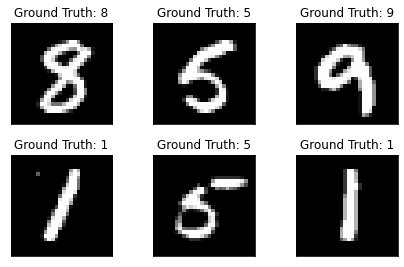

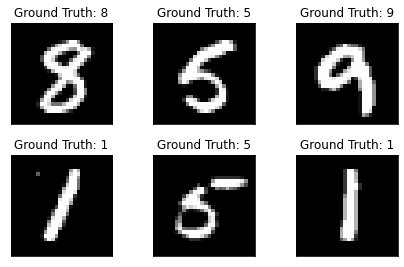

In [4]:
## Print example
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [5]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(g_input_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, g_output_dim), 
            nn.Tanh())

    def forward(self, z):
        image = self.model(z)
        image = image.view(image.size(0), -1)
        return image

In [6]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(d_input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, image):
        img_flat = image.view(image.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [7]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [8]:
print(G, D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

In [9]:
# optimizer
lr = 0.00005
n_critic =  5
clip_value = 0.01
G_optimizer = torch.optim.RMSprop(params=[p for p in G.parameters() if p.requires_grad], lr=lr)
D_optimizer = torch.optim.RMSprop(params=[p for p in D.parameters() if p.requires_grad], lr=lr)

In [10]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
epochs = 200
batches_done = 0
list_loss_D = []
list_loss_G = []
for epoch in range(epochs):

    for i, (imgs, _) in enumerate(train_loader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        D_optimizer.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], z_dim))))

        # Generate a batch of images
        fake_imgs = G(z).detach()
        # Adversarial loss
        d_loss = -torch.mean(D(real_imgs)) + torch.mean(D(fake_imgs))

        d_loss.backward()
        D_optimizer.step()

        # Clip weights of discriminator
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            G_optimizer.zero_grad()

            # Generate a batch of images
            gen_imgs = G(z)
            # Adversarial loss
            g_loss = -torch.mean(D(gen_imgs))


            g_loss.backward()
            G_optimizer.step()

            # add loss to list
            list_loss_D.append(d_loss.item())
            list_loss_G.append(g_loss.item())
        
        if i % 300 == 0:
            print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item()))

    if epoch % 5 == 0:
        save_image(gen_imgs.view(gen_imgs.size(0), 1, 28, 28), os.path.join(sample_dir, "%d.png" % epoch), nrow=5, normalize=True)

torch.save(G, os.path.join(ROOT, 'G.pt'))
torch.save(D, os.path.join(ROOT, 'D.pt'))

[Epoch 0/200] [Batch 0/600] [D loss: 0.009470] [G loss: -0.497173]
[Epoch 0/200] [Batch 300/600] [D loss: -0.089683] [G loss: -0.787237]
[Epoch 1/200] [Batch 0/600] [D loss: -0.040113] [G loss: -0.741836]
[Epoch 1/200] [Batch 300/600] [D loss: -0.059100] [G loss: -0.541385]
[Epoch 2/200] [Batch 0/600] [D loss: -0.114405] [G loss: -0.450375]
[Epoch 2/200] [Batch 300/600] [D loss: -0.121942] [G loss: -0.474418]
[Epoch 3/200] [Batch 0/600] [D loss: -0.125896] [G loss: -0.490049]
[Epoch 3/200] [Batch 300/600] [D loss: -0.159216] [G loss: -0.499638]
[Epoch 4/200] [Batch 0/600] [D loss: -0.099964] [G loss: -0.586161]
[Epoch 4/200] [Batch 300/600] [D loss: -0.128367] [G loss: -0.511880]
[Epoch 5/200] [Batch 0/600] [D loss: -0.088533] [G loss: -0.551305]
[Epoch 5/200] [Batch 300/600] [D loss: -0.100157] [G loss: -0.509938]
[Epoch 6/200] [Batch 0/600] [D loss: -0.102051] [G loss: -0.511029]
[Epoch 6/200] [Batch 300/600] [D loss: -0.097027] [G loss: -0.518641]
[Epoch 7/200] [Batch 0/600] [D loss